Study the Tutorial tutorial_cluster_scanpy_object and the tutorial_Clustering_Methods

Write a brief summary about the following:

-	What are common preprocessing steps? Explain for each step why and when you should execute this step and when not.
-	What visualization methods are used in the cluster methods tutorial? Explain why the selected method is the most appropriate method for the visualization. Bonus points: do this as well for the scanpy tutorial.
-	What performance/evaluation metrics are in the cluster methods tutorial? Explain why the used methods are the most appropriate method for the evaluation.


Bonus:
You practice the steps yourself with the breast_cancer dataset (clustering_data.csv)

---

1. Examining the dataset for missing values, and replacing these.

   Identifying extra steps to complete the dataset (for instance metadata from another file).

   Descriptive statistics, and identifiying outliers. 

   optional: Transforming the data (Tidy-ing up).

   Checking the distribution of the data, skewedness.

   Data standardisation -> all kinds of data into data with a mean of 0 and stdev of 1 

   Data normalisation -> scales data to a specific range, min- max.
   
2. for K-means an inertia/ elbow plot: 
 where one looks for the most drastic decreased in inertia to determine the best fitted amount of clusters. This may be helpfull to either check if the assumed amount of clusters also checks out using the clustering. Or to select an amount when no categories are known. 
 In the case of the wine dataset, unbiased I would say that there are around four clusters reading the elbow plot.
The dendogram fits the agglomerative clustering well as a visualizing tool. The techinque starts at the bottom with clusters based on an embedding, and continues to 'attach' clusters into a new one to become the new cluster untill all is connected in a single one. This exact process is shown in the dendogram. 

Scanpy:
The clusters are found using Louvain clustering method, the samples are then separated with Uniform Manifold Approximation and Projection (UMAP) with the colouring based on the clusters.
 


3. For evaluating the use of Kmeans, it is used as a feature in the RandomForestClassifier.
However in the outcome, the average Area Under the curve and Receiver Operator Characteristic scores (AUC, ROC) of the example with the Kmeans feature added performs a bit worse than the one without. In contrast to the comments in the notebook.

In the last part different cluster sizes are tried in a logistic regression estimator.
It shows that for some cluster sizes it performs better than others. 


---







Now I will apply these principles on the breast-cancer.csv data from: https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset

In [77]:
#load modules
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("dark_background")

In [78]:
# load the data
with open('config.yaml', 'r') as conf:
    config = yaml.load(conf, yaml.SafeLoader)

bc_df = pd.read_csv(config['bc_data'])

bc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Loaded the data, checked the data (types). The diagnosis type we will change to str()

In [79]:
bc_df.diagnosis = bc_df.diagnosis.astype(str)

In [80]:

# check the sample types
print(f'Unique types: {bc_df.diagnosis.unique()}')
# check missing values
print(f'missing values: {bc_df.isnull().values.sum()}')


Unique types: ['M' 'B']
missing values: 0


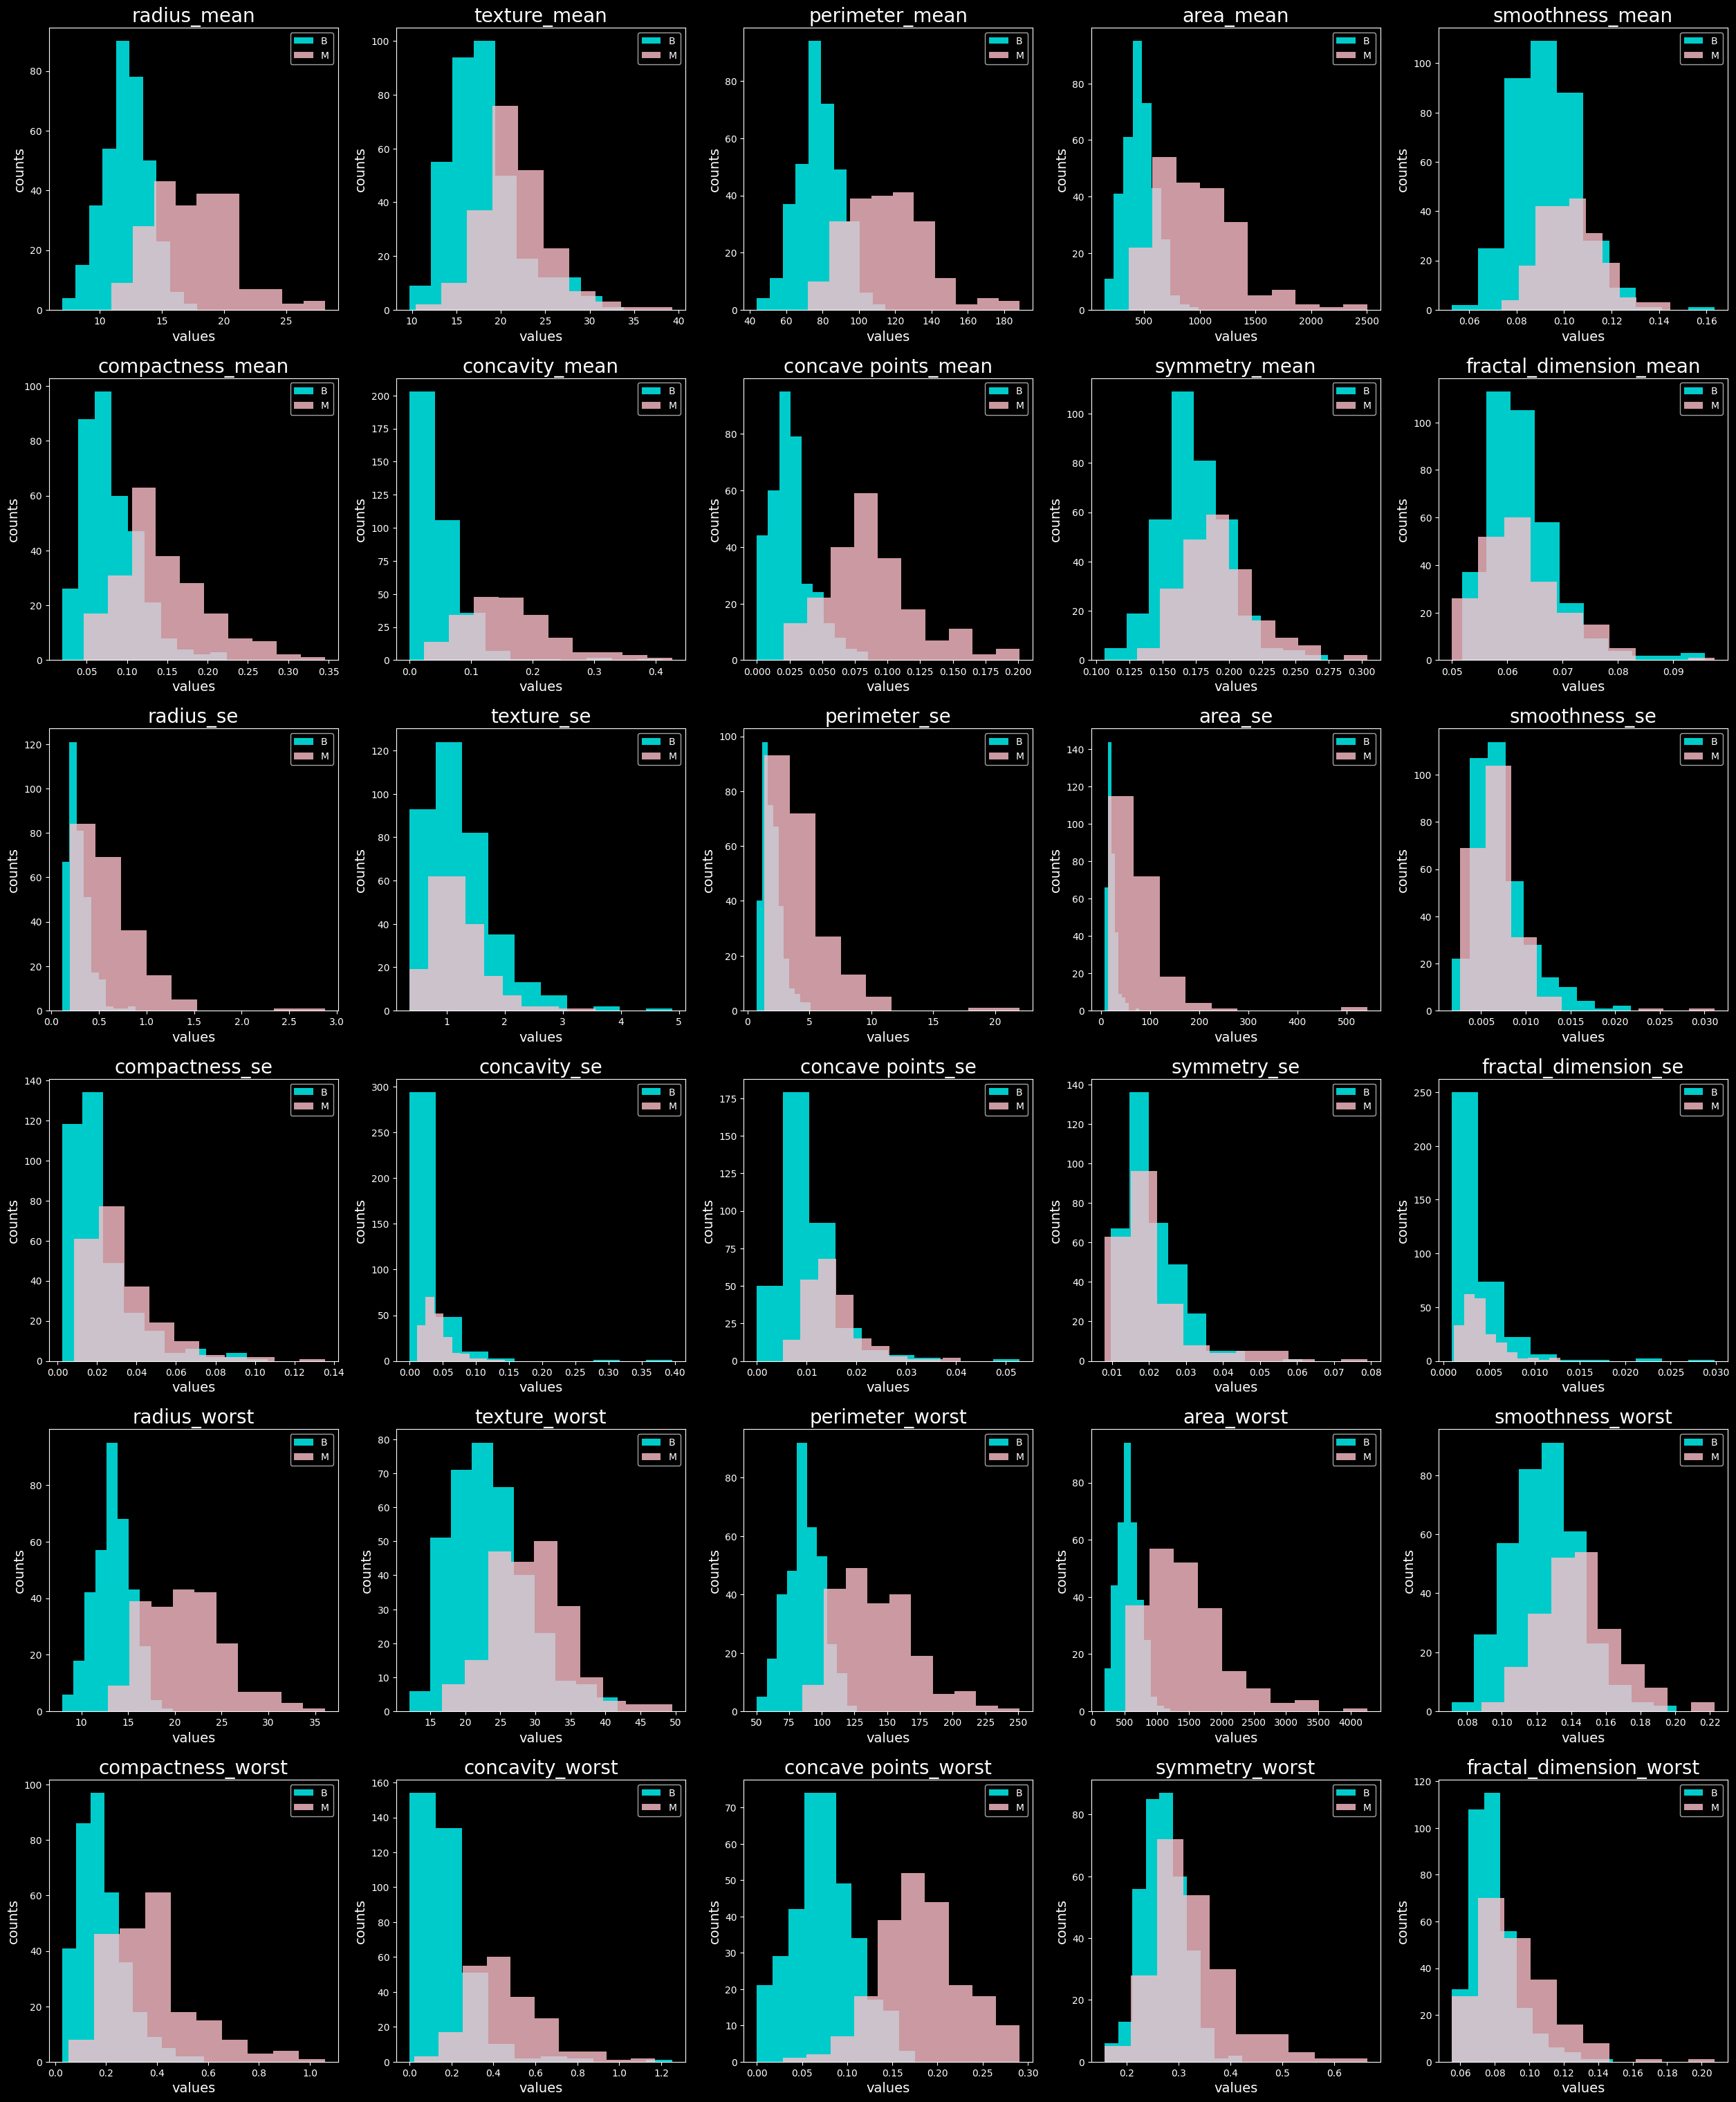

In [81]:
#checking the skewedness with a histogram

fig, ax = plt.subplots(6,5, figsize=(5*5,5*6))
fig.tight_layout(h_pad=5,w_pad=3)
ax = ax.flatten()
for c, i in enumerate(bc_df.columns[2:]):
    try:
        ax[c].hist(bc_df[i][bc_df.diagnosis == 'B'], alpha=0.8, label= 'B', color = 'cyan')
        ax[c].hist(bc_df[i][bc_df.diagnosis == 'M'], alpha=0.8, label= 'M', color = 'pink')
        ax[c].set_xlabel('values', size=14)
        ax[c].set_ylabel('counts', size=14)
        ax[c].legend()
        ax[c].set_title(i, size=20)
    except IndexError:
        ax[c].clear()

As we can see in the plots above is that the values are wildly different, and for some data there is skew but it is limited. 
Also there is a notable difference between the M and B categories for some variables.

In [82]:
from sklearn.preprocessing import StandardScaler
# Data standardization
sc = StandardScaler()
scaled_data = sc.fit_transform(bc_df.iloc[:,2:])

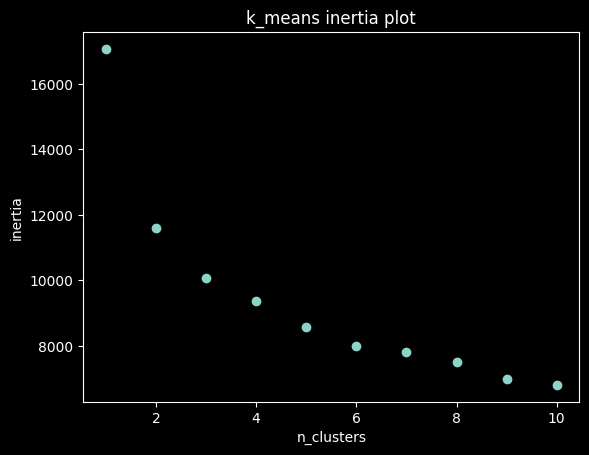

In [83]:
from sklearn.cluster import KMeans
# clustering with k-means

km = KMeans

fig, ax = plt.subplots()
inertia = [k.inertia_ for k in [km(n_clusters=n, n_init='auto').fit(scaled_data) for n in range(1,11,1)]]
ax.scatter(x=range(1,11,1),y=inertia)
ax.set_title("k_means inertia plot")
ax.set_xlabel("n_clusters")
ax.set_ylabel("inertia")
plt.show()

Above the highest (local) loss of inertia is between 1 and 2. To check this we will decompose the data and plot the principle components. Here we will demonstrate it for 2-4 clusters with kmeans.


In [84]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

PC1 = pca.fit_transform(scaled_data)[:,0]
PC2 = pca.fit_transform(scaled_data)[:,1]

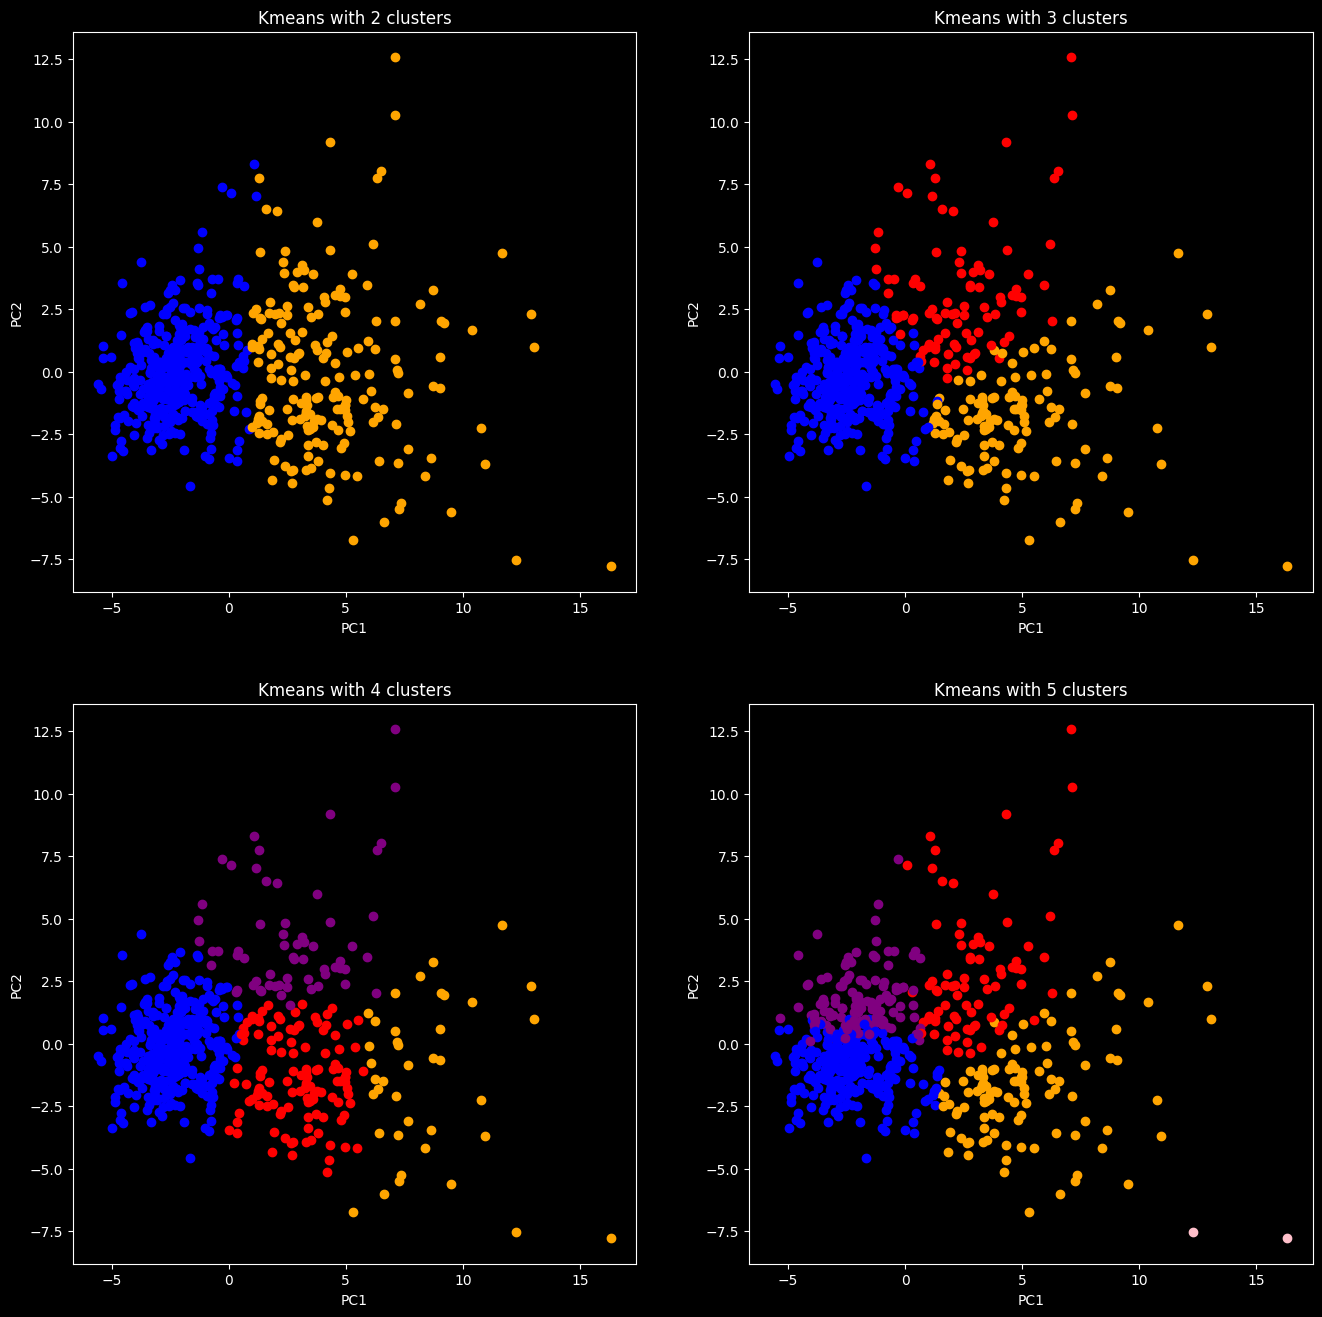

In [85]:
kms = [km(n_clusters=n, n_init='auto') for n in np.arange(2,6)]

km_vals = [k_m.fit_predict(scaled_data) for k_m in kms]

fig, axes = plt.subplots(2,2,figsize=(16,16))

colors = {0:'blue',1:'orange',2:'red',3:'purple',4:'pink'}

c = 1
for ax, kmval in zip(axes.flat, km_vals):
    c += 1
    for pc1, pc2, val in zip(PC1,PC2,kmval):
        ax.scatter(x=pc1, y=pc2, c=colors[val])
        ax.set_ylabel("PC2")
        ax.set_xlabel("PC1")
        ax.set_title(f"Kmeans with {c} clusters")

The plot above shows the different assignments to clusters by kmeans.
My interpretation of the plot is that either two or three clusters is most appropriate, at least in the two dimensions of the PCA. 